In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import numpy as np
import ipywidgets as widgets
import mixbox
from bo_serving.botorch_serving import botorch_optimizer
import matplotlib.pyplot as plt

## Intro

Goal: Set up the bayesian optimization 'backend' for the color mixing experiment, and test it with simulated color mixing

## 1. Define Obective

The objective of this experiment is to replicate a specific but arbitrary color. To define this objective, pick a color. We will work in the RGB color space for all bayesian optimization components. (note the Jubilee experiment will run with real paints). 

This code lets us use the system's graphical color picker tool to select a color. Alternatively, we could just enter an RGB value

In [4]:
def select_a_color():
    def pick_a_color():
        color_picker = widgets.ColorPicker(
            concise=False,
            description='Pick a color',
            value='blue',
            disabled=False
        )
        return color_picker
    
    color_picker = pick_a_color()
    target_rgb_output = []
    
    def on_color_change(change):
        hexcode = change['new']
        target_rgb = tuple(int(hexcode.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        target_rgb_output.clear()
        target_rgb_output.extend(target_rgb)
    color_picker.observe(on_color_change, names='value')
    
    display(color_picker)

    return target_rgb_output

In [5]:
target_color = select_a_color()

ColorPicker(value='blue', description='Pick a color')

## 2. Define a performance scoring function

Here, we will use euclidean distance between the measured outcome and the target color in RGB space. 

In [6]:
def calculate_color_score(target_color, observed_color):
    distance = [np.abs(target_color[i] - observed_color[i]) for i in range(len(target_color))]
    score = np.linalg.norm(distance)

    return score

## 2. Select Parameter Space

Now choose the colors that are available as base colors for mixing. We are using a color mixing theory for paints, so an a-priori reasonable selection would be red, yellow, blue, black, and white. However, we can choose this parameter space however we want. 

Our bayesian optimization campaign will select the ratios of each color to mix. The output of the bayesian optimizer will be a list of volume fractions. Each color can have a volume fraction between 0 and 1. Theoretically we might want to place independent volume fractions on each color, but we will skip that for simplicity. 

In [8]:
base_color_1 = select_a_color()
base_color_2 = select_a_color()
base_color_3 = select_a_color()
base_color_4 = select_a_color()
base_color_5 = select_a_color()

ColorPicker(value='blue', description='Pick a color')

ColorPicker(value='blue', description='Pick a color')

ColorPicker(value='blue', description='Pick a color')

ColorPicker(value='blue', description='Pick a color')

ColorPicker(value='blue', description='Pick a color')

In [9]:
stock_colors = [base_color_1, base_color_2, base_color_3, base_color_4, base_color_5]

## 3. Set up 'experiment' execution

Here, we will use a color mixing library to virtually execute our experiment. Next we will do this with Jubilee


In [10]:
class ColorMixExperiment:

    def __init__(self, colors):
        """"
        Class to simulate a color mixing experiment

        :param colors: List of tuples of RGB values that are available as the stock colors for mixing
        :type colors: list
        """

        self.colors = colors

    def run_experiment(self, weights):
        """
        Mix colors using the mixbox package.
        
        Args:
        - colors: List of RGB tuples representing the colors to mix.
        - weights: List of weights corresponding to each color.
        
        Returns:
        - Tuple containing the mixed color in RGB space.
        """
        colors = [mixbox.rgb_to_latent(color) for color in self.colors]
        mixed_colors = [0]*mixbox.LATENT_SIZE
    
        for color, weight in zip(colors, weights):
            for i in range(mixbox.LATENT_SIZE):
                mixed_colors[i] += color[i] * weight
        
        mixed_rgb = mixbox.latent_to_rgb(mixed_colors)
    
        return mixed_rgb

In [11]:
experiment_executor = ColorMixExperiment(stock_colors)

## 4. Set up bayesian optimization 'model'

We will be using an existing BO implementation that uses the BoTorch library. There are lots of good options for bayesian optimization depending on how in-the-weeds you want to be. 

Things to consider when implementing Bayesian optimization:
- Parameter space: Continuous (ex. concentration) vs discrete (ex. chemical identity of component) vs. mixed (both in same experiment). Complex parameter spaces can have lots of gotchas and might make using a higher-level library worth it
- Surrogate model: The machine learning model that makes predictions about the performance of the parameter space based on the observed experiments. Default choice is usually Gaussian Process Regression
- For GPR model: Kernel/covariance function. Defines a measure of distance between points in parameter space. Many kernels have parameters to select as well
- Acquisition function: This 'interprets' the surrogate model predictions to determine the next points to sample. Usually framed as an 'explore vs. exploit' tradeoff. Many have additional parameters to select

Here, we will be using a fairly standard configuration: 
- Single-task gaussian process regression as surrogate model
- Matern kernel with $\nu = 5/2$ (common selection in materials work)
- Log expected improvement acquisition function (Botorch reccomended starting point)

These selections are all made behind the scenes in BoTorchOptimizer code.

In [18]:
bounds = [(0,1.0)]*len(stock_colors)
n_dims_x = len(stock_colors)
batch_size = 1
n_random_trials = 5
n_bo_trials = 12
unique_id = 42
task = 'minimize'

BoTorchOptimizer = botorch_optimizer.BoTorchOptimizer(bounds, n_dims_x, batch_size, n_random_trials, n_bo_trials, unique_id, task)

## 5. Collect random initial data

This is handled for us by the BoTorchOptimizer class. We will break it out separatley here for posterity. 

In [20]:
observed_colors = []

for i in range(n_random_trials):
    print(f'Getting trial {i+1}')
    experiment_point, trial_index = BoTorchOptimizer.get_next_trial()
    #BotorchOptimizer returns a dictionary:
    experiment_point = list(experiment_point.values())
    print('Running "experiment"')
    mixed_result = experiment_executor.run_experiment(experiment_point)
    observed_colors.append(mixed_result)
    print('Calculating color score')
    score = calculate_color_score(target_color, mixed_result)
    BoTorchOptimizer.update(trial_index, score)
    
    

Getting trial 1
shuffled array
New parameterization generated with random sampling
Running "experiment"
Calculating color score
Initializing model
Getting trial 2
shuffled array
New parameterization generated with random sampling
Running "experiment"
Calculating color score
Initializing model
Getting trial 3
shuffled array
New parameterization generated with random sampling
Running "experiment"
Calculating color score
Initializing model
Getting trial 4
shuffled array
New parameterization generated with random sampling
Running "experiment"
Calculating color score
Initializing model


/home/brendenpelkie/miniconda3/envs/jubilee/lib/python3.9/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/brendenpelkie/miniconda3/envs/jubilee/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


Getting trial 5
shuffled array
New parameterization generated with random sampling
Running "experiment"
Calculating color score
Initializing model


## 6. Run bayesian optimization to optimize 'samples'

In [ ]:
for i in range(n_bo_trials):
    print(f'Getting trial {n_random_trials+i+1}')
    experiment_point, trial_index = BoTorchOptimizer.get_next_trial()
    #BotorchOptimizer returns a dictionary:
    experiment_point = list(experiment_point.values())
    print('Running "experiment"')
    mixed_result = experiment_executor.run_experiment(experiment_point)
    observed_colors.append(mixed_result)
    print('Calculating color score')
    score = calculate_color_score(target_color, mixed_result)
    BoTorchOptimizer.update(trial_index, score)
    #visualize(observed_colors, BoTorchOptimizer)
    

## 8. Look at results:

Text(0, 0.5, 'Loss value')

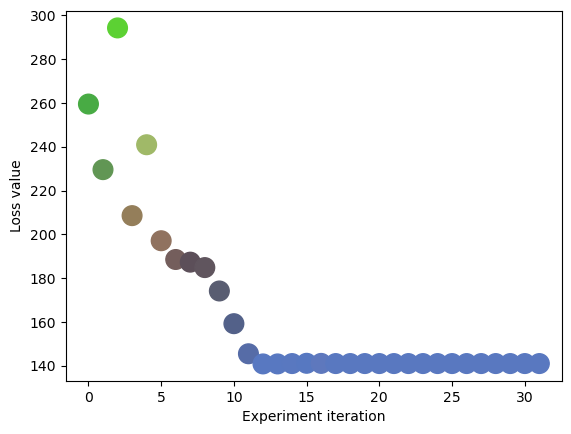

In [32]:
# get data in the right form for plotting
norm_colors = [[c/255 for c in rgb] for rgb in observed_colors]
loss_vals = BoTorchOptimizer.ExperimentData.get_data()[1].numpy()

fig, ax = plt.subplots()

# plot and update 
ax.scatter(range(len(loss_vals)), loss_vals, marker = 'o', color = norm_colors, s = 200)
ax.set_xlabel('Experiment iteration')
ax.set_ylabel('Loss value')